In [161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from scipy.signal import find_peaks
import yfinance as yf



In [162]:

def load_data(symbol, start_date=None):

    if symbol == 'BTC-USD':
        historical_data_btc = pd.read_csv('historical_btc.csv')
        historical_data_btc['date'] = pd.to_datetime(historical_data_btc['date'])
        last_date = historical_data_btc['date'].max()
        new_data_btc = yf.download(symbol, start=start_date) if start_date else yf.download(symbol, start='1970-01-01')
        new_data_btc = new_data_btc.reset_index()
        new_data_btc = new_data_btc[['Date', 'Close']]
        new_data_btc.columns = ['date', 'btc_price']
        full_data = pd.concat([historical_data_btc, new_data_btc], axis=0)
        full_data = full_data.sort_values('date')
        full_data = full_data[full_data['date'] >= start_date] if start_date else full_data
        full_data['date'] = pd.to_datetime(full_data['date'])
        # we remove dates before start_date

        full_data = full_data.reset_index(drop=False)
        max_date = full_data['date'].max()
        print('Max date loaded:', max_date)
    else:
        new_data_btc = yf.download(symbol, start=start_date)
        new_data_btc = new_data_btc.reset_index()
        new_data_btc = new_data_btc[['Date', 'Close']]
        new_data_btc.columns = ['date', 'btc_price']
        full_data = new_data_btc
        full_data = full_data.sort_values('date')
        full_data = full_data.reset_index(drop=False)
        full_data['date'] = pd.to_datetime(full_data['date'])
        max_date = full_data['date'].max()
        print('Max date loaded:', max_date)

    if symbol == 'SPY':
        full_data['btc_price'] = full_data['btc_price'] * 10   

    return full_data



In [163]:
from scipy.signal import find_peaks
import numpy as np

def get_peaks(full_data, d_days, threshold, d_days2, min_date=None):
    full_data = full_data[['date', 'btc_price']].copy()
    full_data.reset_index(drop=True, inplace=True)
    # print('Getting peaks')

    # Find initial peaks with a specified distance
    peaks, _ = find_peaks(full_data['btc_price'], distance=d_days)
    
    # First pass to identify initial peaks
    clean_peaks = []
    btc_prices = full_data['btc_price'].values
    
    for peak in peaks:
        if not any(btc_prices[peak] < btc_prices[past_peak] for past_peak in clean_peaks):
            if peak + 1 < len(btc_prices):
                right_side = btc_prices[peak + 1:peak + 1 + d_days2]
                if len(right_side) > 0 and (right_side < btc_prices[peak] * (1 - threshold)).any():
                    clean_peaks.append(peak)

    clean_peaks = np.array(clean_peaks)
    
    # Enforce one peak per d_days using a backwards window
    final_peaks = []
    if len(clean_peaks) > 0:
        final_peaks.append(clean_peaks[0])
        for i in range(1, len(clean_peaks)):
            if clean_peaks[i] - final_peaks[-1] >= d_days:
                final_peaks.append(clean_peaks[i])
            elif btc_prices[clean_peaks[i]] > btc_prices[final_peaks[-1]]:
                final_peaks[-1] = clean_peaks[i]

    final_peaks = np.array(final_peaks)
    verified_peaks = final_peaks

    clean_peaks_after_year = verified_peaks

    if min_date:
        min_date_index = full_data[full_data['date'] >= min_date].index[0]
        clean_peaks_after_year = clean_peaks_after_year[clean_peaks_after_year >= min_date_index]
    
    return peaks, clean_peaks_after_year




In [164]:

def get_troughs(full_data, d_days, threshold, min_date):
    full_data = full_data[['date', 'btc_price']].copy()
    full_data.reset_index(drop=True, inplace=True)
    troughs, _ = find_peaks(-full_data['btc_price'], distance=d_days)
    
    # print('Troughs:', troughs   )
    # print('Full data:', full_data)
    clean_troughs = []
    if len(troughs) > 0:
        for i, trough in enumerate(troughs):
            if not any(full_data['btc_price'][trough] > full_data['btc_price'][future_trough] for future_trough in troughs[i:]):
                clean_troughs.append(trough)

    clean_troughs = np.array(clean_troughs)
    # Enforce one peak per d_days using a backwards window
    final_troughs = []
    if len(clean_troughs) > 0:
        final_troughs.append(clean_troughs[0])
        for i in range(1, len(clean_troughs)):
            if clean_troughs[i] - final_troughs[-1] >= d_days:
                final_troughs.append(clean_troughs[i])
            elif full_data['btc_price'][clean_troughs[i]] > full_data['btc_price'][final_troughs[-1]]:
                final_troughs[-1] = clean_troughs[i]
    
    final_troughs = np.array(final_troughs)

    clean_troughs_after_year = final_troughs


    clean_troughs_after_year = clean_troughs_after_year[:-1]

    if min_date:
        min_date_index = full_data[full_data['date'] >= min_date].index[0]
        clean_troughs_after_year = clean_troughs_after_year[clean_troughs_after_year >= min_date_index]


    return troughs, clean_troughs_after_year


In [185]:
def get_frame_plot(full_data, clean_peaks, clean_troughs, peak_model, trough_model, average_model_prices,min_y, max_y, symbol, peak_model_params, trough_model_params, average_model_params, peak_r2, trough_r2, current_date=None, ax=None):
    # fig, axs = plt.subplots(1, 3, figsize=(14, 7.3))

    if ax is None:
        fig, axs = plt.subplots(1, 3, figsize=(14, 7.25))
    else:
        fig, axs = plt.gcf(), ax

    for ax_i in axs:
        ax_i.clear()



    axs[0].plot(full_data['date'], full_data['btc_price'], label='BTC Price')
    axs[0].scatter(full_data['date'][clean_peaks], full_data['btc_price'][clean_peaks], color='red', label='Peaks')
    axs[0].scatter(full_data['date'][clean_troughs], full_data['btc_price'][clean_troughs], color='green', label='Troughs')
    axs[0].plot(full_data['date'], peak_model, color='red', label='Model Peaks')
    axs[0].plot(full_data['date'], trough_model, color='green', label='Model Troughs')
    axs[0].plot(full_data['date'], average_model_prices, color='orange', label='Model Average')
    axs[0].set_title(f'{symbol} price')
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Price')
    axs[0].legend()
    axs[0].set_xlim(full_data['date'].min(), full_data['date'].max())
    axs[0].set_ylim(full_data['btc_price'].min(), full_data['btc_price'].max())
    axs[0].set_title('BTC price')
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Price')
    axs[0].yaxis.set_major_formatter('${:,.0f}'.format)
    axs[0].legend()
    axs[0].set_ylim([0, max_y])  # Set max for the first axis

    # Log scale
    axs[1].plot(full_data['date'], full_data['btc_price'], label='BTC Price')
    axs[1].scatter(full_data['date'][clean_peaks], full_data['btc_price'][clean_peaks], color='red', label='Peaks')
    axs[1].scatter(full_data['date'][clean_troughs], full_data['btc_price'][clean_troughs], color='green', label='Troughs')
    axs[1].plot(full_data['date'], peak_model, color='red', label='Model Peaks')
    axs[1].plot(full_data['date'], trough_model, color='green', label='Model Troughs')
    axs[1].plot(full_data['date'], average_model_prices, color='orange', label='Model Average')
    axs[1].set_xlim(full_data['date'].min(), full_data['date'].max())
    axs[1].set_ylim(full_data['btc_price'].min(), full_data['btc_price'].max())
    axs[1].set_title(f'{symbol} price (log)')
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('Price')
    axs[1].set_yscale('log')
    axs[1].set_ylim([min_y, max_y])  # Set log y range

    # # Log-log scale
    axs[2].plot(full_data.index, full_data['btc_price'], label='BTC Price')
    axs[2].scatter(full_data.index[clean_peaks], full_data['btc_price'][clean_peaks], color='red', label='Peaks')
    axs[2].scatter(full_data.index[clean_troughs], full_data['btc_price'][clean_troughs], color='green', label='Troughs')
    axs[2].plot(full_data.index, peak_model, color='red', label='Model Peaks')
    axs[2].plot(full_data.index, trough_model, color='green', label='Model Troughs')
    axs[2].plot(full_data.index, average_model_prices, color='orange', label='Model Average')
    axs[2].set_title(f'{symbol} price (log-log)')
    axs[2].set_xlabel('Date')
    axs[2].set_ylabel('Price')
    axs[2].set_yscale('log')
    axs[2].set_xscale('log')
    max_index = len(full_data) - 1
    axs[2].set_xticks([1, 10, 100, 1000, max_index])
    axs[2].set_xticklabels([full_data['date'][1].year, full_data['date'][10].year, full_data['date'][100].year, full_data['date'][1000].year, full_data['date'][max_index].year])
    axs[2].yaxis.set_major_formatter('${:,.0f}'.format)
    axs[2].set_ylim([min_y, max_y])


    subtitle = f"Current Date: {current_date.strftime('%Y-%m-%d') if current_date else 'N/A'}\n"
    if peak_model_params is not None:
        subtitle += f"Peak Model Params: a={peak_model_params[0]:.4f}, b={peak_model_params[1]:.4f}, R²={peak_r2:.4f}\n"
    else:
        subtitle += "Peak Model Params: waiting for peaks\n"
    if trough_model_params is not None:
        subtitle += f"Trough Model Params: a={trough_model_params[0]:.4f}, b={trough_model_params[1]:.4f}, R²={trough_r2:.4f}\n"
    else:
        subtitle += "Trough Model Params: waiting for troughs\n"

    if average_model_params is not None:
        subtitle += f"Mid Model Params: a={average_model_params[0]:.4f}, b={average_model_params[1]:.4f}\n"
    else:
        subtitle += "Mid Model Params: waiting for peaks and troughs\n"
    
    fig.suptitle(subtitle)

    plt.subplots_adjust(top=0.8, wspace=0.3)    

    return fig, axs


In [177]:
def get_power_law_model(full_data, samples, text):
    historical_index = full_data.index
    samples_index = full_data.index[samples]
    samples_price = full_data['btc_price'][samples]
    log_samples_index = np.log(samples_index)
    log_samples_price = np.log(samples_price)

    # Fit a linear model to the log-log data
    if len(samples_index) == 0:
        model_price = [None] * len(historical_index)
        return model_price, None, None
    
    model_params = np.polyfit(log_samples_index, log_samples_price, 1)
    model_price = np.exp(model_params[1]) * historical_index**model_params[0]
    model_price_samples = np.exp(model_params[1]) * samples_index**model_params[0]

    # Calculate R^2
    residuals = samples_price - model_price_samples
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((samples_price - np.mean(samples_price))**2)
    r_squared = 1 - (ss_res / ss_tot)
    print(f'{text} R2 = ', r_squared)

    return model_price, model_params, r_squared



WE TRY TO EXTEND MODEL INTO THE FUTURE

In [167]:
def extend_data(full_data,final_year_model_prediction = 2040):
    final_date = pd.to_datetime(f'01-01-{final_year_model_prediction}')
    # we extend full_data to finish at final_date, creating a new row for each day. BTC price is NaN for these rows
    full_data = full_data.set_index('date')
    full_data = full_data.reindex(pd.date_range(full_data.index.min(), final_date, freq='D'))
    # we convert the index to a column
    full_data = full_data.reset_index()
    full_data.columns = ['date', 'btc_price']
    # full_data = full_data.reset_index(drop=False, inplace=True)
    return full_data

Peak Model R2 =  0.9655069335786315
Trough Model R2 =  0.992666581699513


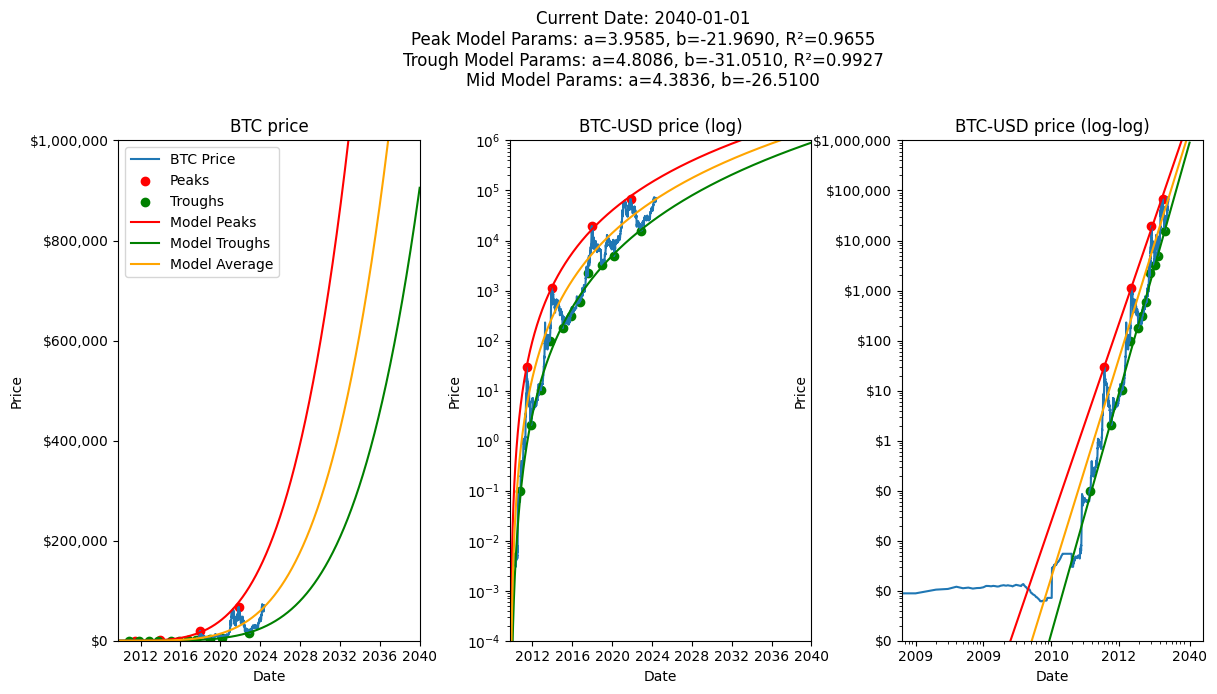

In [168]:
symbol = 'BTC-USD'
min_date_model = '2010-01-01'
final_year_model_prediction = 2040
d_days = 300
d_days2 = 300
threshold = 0.45
full_data = historical_data.copy()
full_data = full_data.drop_duplicates('date')
full_data = full_data[['date', 'btc_price']]
full_data = extend_data(full_data, final_year_model_prediction) if final_year_model_prediction else full_data

min_y = 1e-4
max_y = 1e6

current_date = full_data['date'].max()
    

min_date_model = '2010-01-01'
peaks, clean_peaks = get_peaks(full_data, d_days, threshold, d_days2, min_date)
troughs, clean_troughs = get_troughs(full_data, d_days, threshold, min_date)
peak_model_prices, peak_model_params, peak_r2 = get_power_law_model(full_data, clean_peaks, 'Peak Model')
trough_model_prices, trough_model_params, trough_r2 = get_power_law_model(full_data, clean_troughs, 'Trough Model')
average_model_params = (peak_model_params + trough_model_params) / 2
average_model_prices = np.exp(average_model_params[1]) * full_data.index**average_model_params[0]

fig, ax = get_frame_plot(full_data, clean_peaks, clean_troughs, peak_model_prices, trough_model_prices, average_model_prices, min_y, max_y, symbol, peak_model_params, trough_model_params, average_model_params, peak_r2, trough_r2, current_date)
plt.show()


In [183]:
def animate(i, full_data, d_days, threshold, d_days2, min_y, max_y, symbol, min_date_model, min_year_ani,axs):
    current_date = pd.Timestamp(f'{min_year_ani}-01-01') + pd.DateOffset(months=i)
    temp_data = full_data.copy()
    # temp_data['btc_price'][temp_data['date'] > current_date] = np.nan
    temp_data.loc[temp_data['date'] > current_date, 'btc_price'] = np.nan
    peaks, clean_peaks = get_peaks(temp_data, d_days, threshold, d_days2, min_date_model)
    troughs, clean_troughs = get_troughs(temp_data, d_days, threshold, min_date_model)
    peak_model_prices, peak_model_params, peak_r2 = get_power_law_model(temp_data, clean_peaks, 'Peak Model')
    trough_model_prices, trough_model_params, trough_r2 = get_power_law_model(temp_data, clean_troughs, 'Trough Model')
    average_model_params = (peak_model_params + trough_model_params) / 2 if peak_model_params is not None and trough_model_params is not None else None
    average_model_prices = np.exp(average_model_params[1]) * full_data.index**average_model_params[0] if average_model_params is not None else [None] * len(full_data)

    axs = get_frame_plot(temp_data, clean_peaks, clean_troughs, peak_model_prices, trough_model_prices, average_model_prices, min_y, max_y, symbol, peak_model_params, trough_model_params, average_model_params, peak_r2, trough_r2, current_date, ax=axs)
    return axs

C:\Users\jordi\AppData\Local\Temp\ipykernel_30056\657689247.py:13: RankWarning: Polyfit may be poorly conditioned
  model_params = np.polyfit(log_samples_index, log_samples_price, 1)
C:\Users\jordi\AppData\Local\Temp\ipykernel_30056\657689247.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  r_squared = 1 - (ss_res / ss_tot)


Peak Model R2 =  -inf


C:\Users\jordi\AppData\Local\Temp\ipykernel_30056\657689247.py:13: RankWarning: Polyfit may be poorly conditioned
  model_params = np.polyfit(log_samples_index, log_samples_price, 1)
C:\Users\jordi\AppData\Local\Temp\ipykernel_30056\657689247.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  r_squared = 1 - (ss_res / ss_tot)
C:\Users\jordi\AppData\Local\Temp\ipykernel_30056\657689247.py:13: RankWarning: Polyfit may be poorly conditioned
  model_params = np.polyfit(log_samples_index, log_samples_price, 1)
C:\Users\jordi\AppData\Local\Temp\ipykernel_30056\657689247.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  r_squared = 1 - (ss_res / ss_tot)


Peak Model R2 =  -inf
Trough Model R2 =  -inf


C:\Users\jordi\AppData\Local\Temp\ipykernel_30056\657689247.py:13: RankWarning: Polyfit may be poorly conditioned
  model_params = np.polyfit(log_samples_index, log_samples_price, 1)
C:\Users\jordi\AppData\Local\Temp\ipykernel_30056\657689247.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  r_squared = 1 - (ss_res / ss_tot)


Peak Model R2 =  -inf
Trough Model R2 =  1.0
Peak Model R2 =  1.0
Trough Model R2 =  0.9998170619185069
Peak Model R2 =  1.0
Trough Model R2 =  0.7669522608279135
Peak Model R2 =  1.0
Trough Model R2 =  0.8804005934215233
Peak Model R2 =  1.0
Trough Model R2 =  0.9228110110153591
Peak Model R2 =  1.0
Trough Model R2 =  0.9698344270913707
Peak Model R2 =  0.9989786615682136
Trough Model R2 =  0.7857522156526497
Peak Model R2 =  0.9989786615682136
Trough Model R2 =  0.9201565226228238
Peak Model R2 =  0.9989786615682136
Trough Model R2 =  0.9201565226228238
Peak Model R2 =  0.9989786615682136
Trough Model R2 =  0.9512750269946085
Peak Model R2 =  0.9655069335786315
Trough Model R2 =  0.9512750269946085
Peak Model R2 =  0.9655069335786315
Trough Model R2 =  0.992666581699513


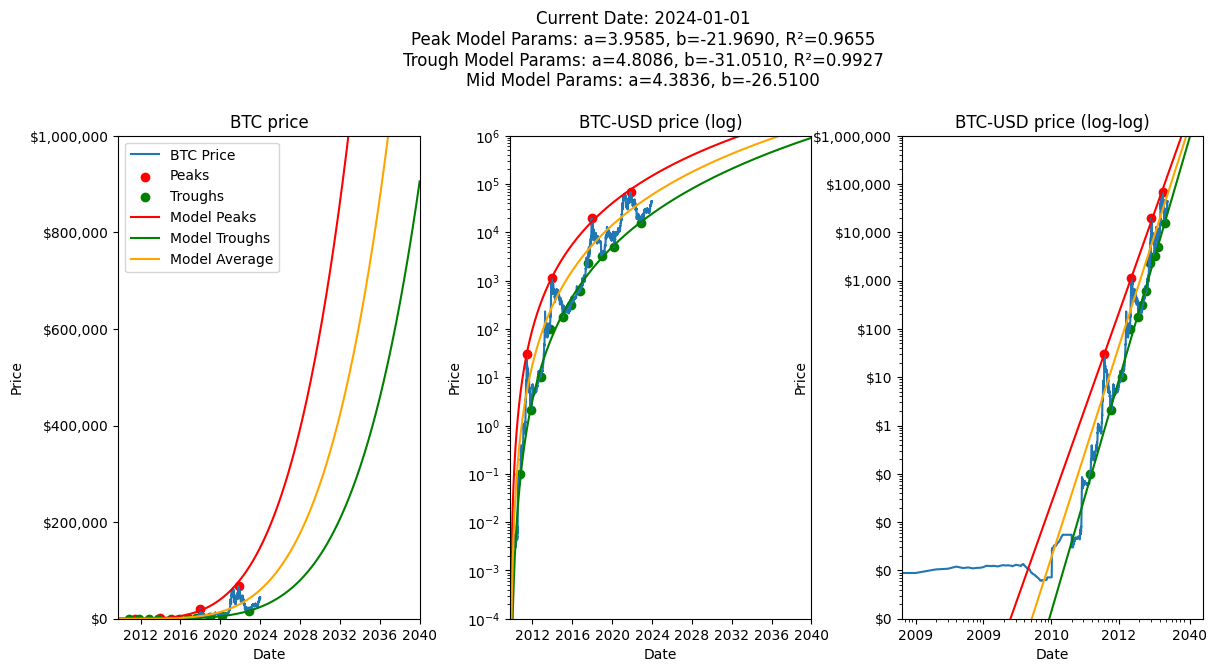

In [186]:
symbol = 'BTC-USD'
min_date_model = '2010-01-01'
final_year_model_prediction = 2040
d_days = 300
d_days2 = 300
threshold = 0.45
full_data = historical_data.copy()
full_data = full_data.drop_duplicates('date')
full_data = full_data[['date', 'btc_price']]
full_data = extend_data(full_data, final_year_model_prediction) if final_year_model_prediction else full_data
min_year_ani = 2010
max_year_ani = 2024
months_step = 12

min_y = 1e-4
max_y = 1e6


fig, axs = plt.subplots(1, 3, figsize=(14, 7))
f_args = (full_data, d_days, threshold, d_days2, min_y, max_y, symbol, min_date_model, min_year_ani,axs)

ani = FuncAnimation(fig, animate, frames=range(0, (max_year_ani-min_year_ani)*12 + 1,months_step), fargs=f_args, interval=200)

ani.save('new_flow_btc1.gif', writer=PillowWriter(fps=1))

plt.show()
